<a href="https://colab.research.google.com/github/majamil16/weather_forecasting_LSTM/blob/main/weather_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Meteostat library is used to retrieve the weather data
!pip install meteostat

In [ ]:
# import libraries
import pandas as pd
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Daily, Stations

In [ ]:
# to make graphs prettier :)
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [ ]:
# retrieve the last 15 years of weather data
start = datetime(2008, 3, 1)
end = datetime(2022, 3, 1)

# Rochester Int'l Airport weather station - https://meteostat.net/en/station/72529
STATION = '72529'

# Get daily data from the station
data = Daily(STATION, start=start, end=end)
data = data.normalize()
data = data.interpolate() # fill in gaps where data is missing
data = data.fetch()


In [ ]:
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2008-03-01,7.3,3.9,11.4,3.3,NaN,126.0,14.6,NaN,1019.1,NaN
2008-03-02,5.9,2.0,8.0,0.0,NaN,126.0,13.0,NaN,1033.5,NaN
2008-03-03,4.6,1.0,8.5,9.4,NaN,88.0,21.2,NaN,1019.8,NaN
2008-03-04,5.0,0.0,8.0,0.0,NaN,85.4,7.6,NaN,1026.5,NaN
2008-03-05,4.2,-1.0,8.5,0.0,NaN,82.8,6.1,NaN,1029.1,NaN


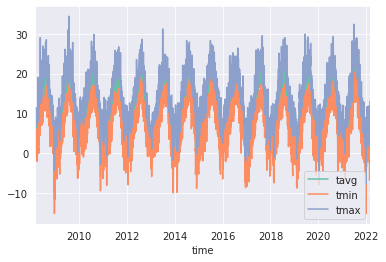

In [ ]:
"""
Features of dataset : 

tavg	The average air temperature in °C	Float64
tmin	The minimum air temperature in °C	Float64
tmax	The maximum air temperature in °C	Float64
prcp	The daily precipitation total in mm	Float64
snow	The snow depth in mm	Float64
wdir	The average wind direction in degrees (°)	Float64
wspd	The average wind speed in km/h	Float64
wpgt	The peak wind gust in km/h	Float64
pres	The average sea-level air pressure in hPa	Float64
tsun	The daily sunshine total in minutes (m)	Float64
"""

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

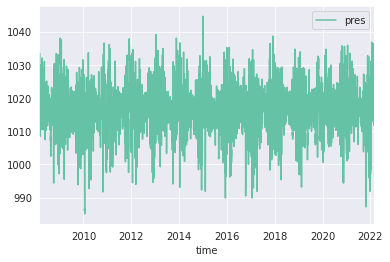

In [ ]:
# Plot pressure data
data.plot(y=['pres'])
plt.show()

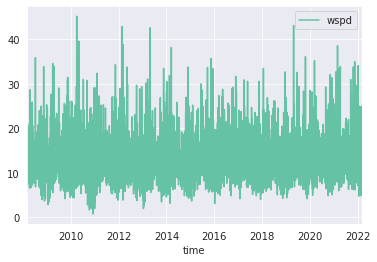

In [ ]:
# Plot average wind speed data
data.plot(y=['wspd'])
plt.show()

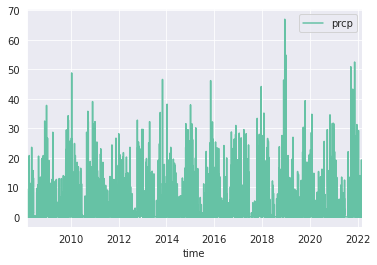

In [ ]:
# Plot daily precipitation total data
data.plot(y=['prcp'])
plt.show()

## Data Preprocessing and Formatting

### Impute Missing Values

We need to make sure there is no missing data in our training set. Note that `meteostat` has already done interpolation of data to fill in some gaps (`data.interpolate()`), but there may still be some data missing.

### Format our data for LSTM

For LSTM, we need to format the data into sequences. This involves reshaping the input dataframe (where each row represents the 6 features for 1 day) into sequences where we use the previous 7 days of data to predict the next 1 day.

In [ ]:
# Columns we are using
feature_names = ['pres', 'wspd','prcp', 'tavg', 'tmin', 'tmax' ] # pressure, wind speed, precipitation, avg, min, max temp

data = data[feature_names]

dates = data.index.to_numpy()
len(dates) / 365

14.01095890410959

In [ ]:
# Check for columns that contain nan values
nan_cols = data.isnull().any()
print(nan_cols)

# 'prcp' has some missing values - find out how many
n_nan_prcp = sum(data.prcp.isnull())
pct_nan = sum(data.prcp.isnull())/len(data.prcp) * 100
print(f"{n_nan_prcp} / {len(data.prcp)} missing values ({pct_nan}%)")

pres    False
wspd    False
prcp     True
tavg    False
tmin    False
tmax    False
dtype: bool
6 / 5114 missing values (0.11732499022291748%)


In [ ]:
# look at the dates for which the prcp is missing?
data.prcp[data.prcp.isnull()]

time
2013-06-04   NaN
2013-06-05   NaN
2013-06-06   NaN
2013-06-07   NaN
2013-06-08   NaN
2013-06-09   NaN
Name: prcp, dtype: float64

In [ ]:
# interestingly - there is 1 week of missing data
# let's look at the week before and after to get an idea of the precipitation amounts
null_index = data.prcp[data.prcp.isnull()].index
data.prcp[null_index]

time
2013-06-04   NaN
2013-06-05   NaN
2013-06-06   NaN
2013-06-07   NaN
2013-06-08   NaN
2013-06-09   NaN
Name: prcp, dtype: float64

In [ ]:
prior_wk = null_index - pd.Timedelta(6, unit='D') 
post_wk = null_index + pd.Timedelta(7, unit='D') 

In [ ]:
data.prcp[prior_wk]

time
2013-05-29    13.2
2013-05-30     3.3
2013-05-31     0.0
2013-06-01     0.0
2013-06-02     0.0
2013-06-03     0.0
Name: prcp, dtype: float64

In [ ]:
data.prcp[post_wk]

time
2013-06-11    0.0
2013-06-12    0.0
2013-06-13    0.0
2013-06-14    0.4
2013-06-15    0.0
2013-06-16    0.0
Name: prcp, dtype: float64

In [ ]:
# Seems like it was a dry week! It's probably safe to fill nan with 0.
data.prcp = data.prcp.fillna(0)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# finally - make sure dtype is float
data = data.astype(float)

In [ ]:
print(data.dtypes)

pres    float64
wspd    float64
prcp    float64
tavg    float64
tmin    float64
tmax    float64
dtype: object


In [ ]:
from sklearn.preprocessing import StandardScaler
# LSTM requires standardization (mean=0, var=unit) of data to ensure convergence (use tanh range=(-1,1) and sigmoid range=(0,1))

scaler = StandardScaler()
scaler.fit(data)

scaled_data = scaler.transform(data)
scaled_data

array([[ 0.29768803,  0.22461925,  0.02187073, -0.55296741, -0.54694086,
        -0.43709742],
       [ 2.3214989 , -0.07114994, -0.50011312, -0.78913608, -0.88219335,
        -0.95873846],
       [ 0.39606773,  1.44466715,  0.98674996, -1.00843557, -1.05864202,
        -0.88202654],
       ...,
       [-0.06772226,  1.11192681,  2.5527015 , -0.50235983, -0.45871653,
        -0.54449411],
       [-0.74232589,  0.96404222,  1.28728611, -0.51922902, -0.10581918,
        -0.88202654],
       [-0.15204772,  0.33553269,  0.05350611, -0.08063005,  0.0176949 ,
        -0.19161929]])

In [ ]:
print(f"Data shape ==> {scaled_data.shape}")

Data shape ==> (5114, 6)


In [ ]:
def shape_data(dataset, n_past=7, n_future=1, y_var_ind=3):
  """
  dataset = the dataset (scaled, or the dataframe - expects as numpy arrays)
  n_past = how many past days we want to use to predict the {n_future} days ahead
  n_future = how many days ahead we want to look. Default 1
  y_var_ind = the index of the feature (here, tmax) in the dataframe. default to 3 because we want to predict the avg temp
  """

  # declare arrays to store our train and test data
  x_train = []
  y_train = []

  # loop through the dataset, starting at index n_past 
  for i in range(n_past, len(dataset) - n_future +1):
    # look BACK n_past days - this is our 'x' data
    x_train.append(dataset[i - n_past:i, 0:dataset.shape[1]])
    # we are using the above to predict n_future days
    y_train.append(dataset[i + n_future - 1:i + n_future, y_var_ind])

  x_train, y_train = np.array(x_train), np.array(y_train)

  return x_train, y_train

In [ ]:
x_train, y_train = shape_data(scaled_data)

In [ ]:
x_traina, y_traina = shape_data(data.to_numpy())
y_traina

array([[ 8.3],
       [ 7.1],
       [ 8.7],
       ...,
       [ 7.6],
       [ 7.5],
       [10.1]])

In [ ]:
data.tail(25)

,pres,wspd,prcp,tavg,tmin,tmax
time,,,,,,
2022-02-05,1034.9,8.7,0.0,5.7,3.9,7.5
2022-02-06,1029.5,7.6,0.0,3.5,-0.4,7.4
2022-02-07,1027.5,14.6,0.0,7.4,2.9,11.8
2022-02-08,1035.8,13.3,2.9,5.5,2.9,8.0
2022-02-09,1036.4,8.3,0.9,7.3,5.8,8.7
2022-02-10,1033.0,7.6,0.2,5.1,3.4,6.8
2022-02-11,1032.8,15.1,0.0,5.1,2.2,8.0
2022-02-12,1027.9,11.5,0.0,3.6,-0.2,7.4
2022-02-13,1020.7,7.0,0.0,4.4,-0.8,9.6


In [ ]:
"""
Check the shape of our training data - 
x_train is of shape ((n_days_total-n_past), n_past, n_features)
y_train is of shape ((n_days_total-n_past), 1)

where n_days_total is the total length of the original dataset - aka the 15 years of data.
"""

print(f"x_train shape ==> {x_train.shape}")
print(f"y_train shape ==> {y_train.shape}")

x_train shape ==> (5107, 7, 6)
y_train shape ==> (5107, 1)


In [ ]:
x_train[0]

array([[ 0.29768803,  0.22461925,  0.02187073, -0.55296741, -0.54694086,
        -0.43709742],
       [ 2.3214989 , -0.07114994, -0.50011312, -0.78913608, -0.88219335,
        -0.95873846],
       [ 0.39606773,  1.44466715,  0.98674996, -1.00843557, -1.05864202,
        -0.88202654],
       [ 1.33770195, -1.06937095, -0.50011312, -0.94095881, -1.2350907 ,
        -0.95873846],
       [ 1.70311224, -1.34665456, -0.50011312, -1.07591234, -1.41153937,
        -0.88202654],
       [ 1.12688832, -1.40211129, -0.50011312, -1.00843557, -1.14686636,
        -0.49846696],
       [ 0.76147802, -0.36691913, -0.3419362 , -0.45175226, -1.41153937,
        -0.46778219]])

## Defining the LSTM Model

In [ ]:
## Import keras Sequential model & Layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
# We want the input dimensions of our model to be (seq_length, n_features)
input_dim = (x_train.shape[1], x_train.shape[2])

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=input_dim, return_sequences=True)) # return the full sequence instead of just the last output. so the output shape of this layer is (None, 7, 64)
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# save the model
root_dir = "/content/drive/My Drive"
proj_dir = f"{root_dir}/Colab Notebooks/LEARNING"
model_dir = f"{proj_dir}/models"
model.save(f"{model_dir}/lstm_weather.h5")

In [ ]:
# fit the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=.2, verbose=1)

Epoch 1/5
256/256 [==============================] - 7s 13ms/step - loss: 0.1899 - val_loss: 0.1310
Epoch 2/5
256/256 [==============================] - 3s 10ms/step - loss: 0.1221 - val_loss: 0.0929
Epoch 3/5
256/256 [==============================] - 3s 10ms/step - loss: 0.1028 - val_loss: 0.0824
Epoch 4/5
256/256 [==============================] - 3s 10ms/step - loss: 0.0939 - val_loss: 0.0800
Epoch 5/5
256/256 [==============================] - 2s 10ms/step - loss: 0.0916 - val_loss: 0.0764


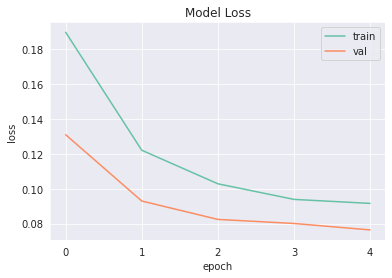

In [ ]:
# Quick plot of the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')

plt.xticks(range(5)) # set the ticks to be integral numbers instead of default float
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.legend()

## Forecasting

Finally - we have a trained model we can use to predict the weather! :) 

In [ ]:
n_days_to_forecast=50  # the number of days in the future we want to forecast using the model
forecast_ts_list = pd.date_range(list(dates)[-1], periods=n_days_to_forecast, freq='1d').tolist() # obtain a list of the actual dates we will be forecasting for -- the 15 days after the end of our training data


# predict the weather for the 15 days
forecast = model.predict(x_train[-n_days_to_forecast:]) #shape = (n, 1) where n is the n_days_for_prediction


In [ ]:
forecast

array([[-1.0928197 ],
       [-0.5377009 ],
       [-0.35998002],
       [-0.654203  ],
       [-0.58990675],
       [-0.8707403 ],
       [-0.82735705],
       [-0.8788773 ],
       [-0.8438888 ],
       [-0.60215575],
       [-0.5141498 ],
       [-1.0467744 ],
       [-1.1351737 ],
       [-1.4109579 ],
       [-1.2619934 ],
       [-1.4599801 ],
       [-1.4658341 ],
       [-1.5119587 ],
       [-1.3655065 ],
       [-1.1957556 ],
       [-0.9403461 ],
       [-1.3400227 ],
       [-1.5450748 ],
       [-1.844036  ],
       [-1.0606822 ],
       [-0.9049693 ],
       [-0.9531781 ],
       [-1.2220936 ],
       [-0.6881518 ],
       [-0.9794913 ],
       [-0.6963466 ],
       [-0.97242254],
       [-1.1104898 ],
       [-1.2911017 ],
       [-1.10139   ],
       [-0.88411826],
       [-0.90792096],
       [-0.9203889 ],
       [-0.7321106 ],
       [-0.8074401 ],
       [-0.8255439 ],
       [-1.0562882 ],
       [-1.4088178 ],
       [-1.9465357 ],
       [-2.2790043 ],
       [-1

In [ ]:
# Since the forecasted data is still scaled, we need to perform an inverse transformation.
# First, we have to repeat the array elements to be the same shape expected by the scaler (otherwise we will get an error)
# so instead of the above 'column vector' (15,1) we get a matrix of shape (15,6) = (n_days_to_forecast, n_features)
forecast_repeated = np.repeat(forecast, scaled_data.shape[1], axis=1)
forecast_repeated.shape

(50, 6)

In [ ]:
# get the third column - this corresponds to the tavg (same as the y_var_ind parameter in the shape_data function).
y_forecasted = scaler.inverse_transform(forecast_repeated)[:,3]
y_forecasted

array([ 4.099774  ,  7.3904996 ,  8.444023  ,  6.6998787 ,  7.0810246 ,
        5.416253  ,  5.6734276 ,  5.368017  ,  5.575428  ,  7.0084133 ,
        7.5301094 ,  4.372729  ,  3.8487008 ,  2.2138612 ,  3.0969174 ,
        1.9232585 ,  1.8885562 ,  1.6151311 ,  2.4832952 ,  3.4895732 ,
        5.003632  ,  2.6343625 ,  1.4188201 , -0.3534109 ,  4.290284  ,
        5.213345  ,  4.9275646 ,  3.3334424 ,  6.498632  ,  4.7715807 ,
        6.450053  ,  4.813484  ,  3.9950254 ,  2.9243648 ,  4.0489693 ,
        5.336949  ,  5.1958475 ,  5.121938  ,  6.238045  ,  5.7914944 ,
        5.684176  ,  4.316331  ,  2.226548  , -0.9610264 , -2.9318888 ,
        0.20945436,  1.1546695 ,  4.434449  ,  6.3197675 ,  5.663554  ],
      dtype=float32)

In [ ]:
# convert timestamp to date
forecast_dates = [ts.date() for ts in forecast_ts_list]

In [ ]:
df_forecast = pd.DataFrame({'date' : forecast_dates, 'avg temp' : y_forecasted})

In [ ]:
# get the actual values for the days available
start_actuals = datetime(2022, 3, 2)
end_actuals = datetime(2022, 3, 6)

data_actual = Daily(STATION, start=start_actuals, end=end_actuals)
data_actual = data_actual.normalize()
data_actual = data_actual.interpolate() # fill in gaps where data is missing
data_actual = data_actual.fetch()



In [ ]:
data_actual['tavg']

time
2022-03-02     0.3
2022-03-03    -6.1
2022-03-04    -5.6
2022-03-05     1.7
2022-03-06    11.9
Name: tavg, dtype: float64

Text(0, 0.5, 'avg. temp (°C)')

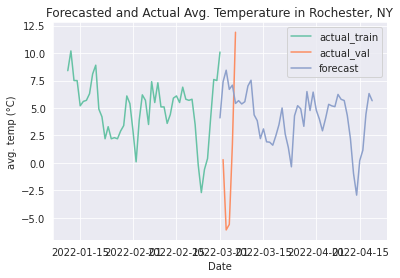

In [ ]:
sns.lineplot(x=data.index[-50:], y=data['tavg'][-50:], label='actual_train')
sns.lineplot(x=data_actual.index, y=data_actual['tavg'], label='actual_val')
sns.lineplot(x=df_forecast['date'], y=df_forecast['avg temp'], label='forecast')

plt.title('Forecasted and Actual Avg. Temperature in Rochester, NY')
plt.xlabel('Date')
plt.ylabel('avg. temp (\N{degree sign}C)')